### Introduction

### Import modules

In [11]:
%matplotlib inline
from __future__ import division
from osgeo import gdal
import numpy as np
import scipy.signal
import os
import matplotlib.pyplot as plt
import nitime.algorithms as tsa
import random
import os
from osgeo import gdal
import scipy.signal

### Compute multitaper + uncertainty

In [12]:
def dB(x, out=None):
    if out is None:
        return 10 * np.log10(x)
    else:
        np.log10(x, out)
        np.multiply(out, 10, out)
        
def mtem(x, y):
    """
    multitaper estimation method
    input:
    x  first time series
    y  second time series

    output:
    fkx  power spectral density x
    fky  power spectral density y
    cxy  cross-spectral density xy
    coh  coherence
    ph  phase between xy at input freq
    
    """
    print ('x size', x.shape)
    print ('y size', y.shape)
    
    # apply multi taper cross spectral density from nitime module
    f, pcsd_est = tsa.multi_taper_csd(np.vstack([x,y]), Fs=1., low_bias=True, adaptive=True, sides='onesided')
    
    # output is MxMxN matrix, extract the psd and csd
    fkx = pcsd_est.diagonal().T[0]
    fky = pcsd_est.diagonal().T[1]
    cxy = pcsd_est.diagonal(+1).T.ravel()
    
    # using complex argument of cxy extract phase component
    ph = np.angle(cxy)
    
    # calculate coherence using csd and psd
    coh = np.abs(cxy)**2 / (fkx * fky)   
    
    return f, fkx, fky, cxy, ph, coh 

def mtem_unct(x_, y_, cf, mc_no=20):
    """
    Uncertainty function using Monte Carlo analysis
    Input:
    x_ = timeseries x
    y_ = timeseries y
    cf = coherence function between x and y
    mc_no = number of iterations default is 20, minimum is 3
    
    Output:
    phif = phase uncertainty bounded between 0 and pi
    """
    print ('iteration no is', mc_no)
    
    data = np.vstack([x_,y_])
    # number of iterations
    # flip coherence and horizontal stack    
    cg = np.hstack((cf[:-1], np.flipud(cf[:-1])))
    
    # random time series fx
    mc_fx = np.random.standard_normal(size=(mc_no,len(data[0])))
    mc_fx = mc_fx / np.sum(abs(mc_fx),axis=1)[None].T
    
    # random time series fy
    mc_fy = np.random.standard_normal(size=(mc_no,len(data[0])))
    mc_fy = mc_fy / np.sum(abs(mc_fy),axis=1)[None].T
    
    # create semi random timeseries based on magnitude squared coherence
    # and inverse fourier transform for ys
    ys = np.real(np.fft.ifft(mc_fy * np.sqrt(1 - cg ** 2))) 
    ys = ys + np.real(np.fft.ifft(mc_fx *cg))
    
    # inverse fourier transform for xs
    xs = np.real(np.fft.ifft(mc_fx))
    
    # spectral analysis
    f_s, pcsd_est = tsa.multi_taper_csd(np.vstack([xs,ys]), Fs=1., low_bias=True, adaptive=True, sides='onesided')
    cxyi = pcsd_est.diagonal(+int(xs.shape[0])).T
    phi = np.angle(cxyi)
    
    # sort and average the highest uncertianties
    pl = int(round(0.975*mc_no)+1)
    phi = np.sort(phi,axis=0)        
    phi = phi[((mc_no+1)-pl):pl]
    phi = np.array([phi[pl-2,:],-phi[pl-mc_no,:]])
    phi = phi.mean(axis=0)#
    phi = np.convolve(phi, np.array([1,1,1])/3)
    phif = phi[1:-1]
    return phif

### Compute PyHANTS

In [13]:
# --------*-*-*-*-*-*--------  WPSProcess  --------*-*-*-*-*-*--------  WPSProcess  --------*-*-*-*-*-*-----
# Computing diagonal for each row of a 2d array. See: http://stackoverflow.com/q/27214027/2459096
def makediag3d(M):
    b = np.zeros((M.shape[0], M.shape[1] * M.shape[1]))
    b[:, ::M.shape[1] + 1] = M
    
    #logging.info('function `makediag3d` complete')    
    return b.reshape(M.shape[0], M.shape[1], M.shape[1]) 

def get_starter_matrix(base_period_len, sample_count, frequencies_considered_count):
    nr = min(2 * frequencies_considered_count + 1,
                  sample_count)  # number of 2*+1 frequencies, or number of input images
    mat = np.zeros(shape=(nr, sample_count))
    mat[0, :] = 1
    ang = 2 * np.pi * np.arange(base_period_len) / base_period_len
    cs = np.cos(ang)
    sn = np.sin(ang)
    # create some standard sinus and cosinus functions and put in matrix
    i = np.arange(1, frequencies_considered_count + 1)
    ts = np.arange(sample_count)
    for column in range(sample_count):
        index = np.mod(i * ts[column], base_period_len)
        # index looks like 000, 123, 246, etc, until it wraps around (for len(i)==3)
        mat[2 * i - 1, column] = cs.take(index)
        mat[2 * i, column] = sn.take(index)

    #logging.info('function `get_starter_matrix` complete')
    return mat

def HANTS(sample_count, inputs,
          frequencies_considered_count=3,
          outliers_to_reject='Lo',
          low=0., high=255,
          fit_error_tolerance=5,
          delta=0.1):
    """
    Function to apply the Harmonic analysis of time series applied to arrays

    sample_count    = nr. of images (total number of actual samples of the time series)
    base_period_len    = length of the base period, measured in virtual samples
            (days, dekads, months, etc.)
    frequencies_considered_count    = number of frequencies to be considered above the zero frequency
    inputs     = array of input sample values (e.g. NDVI values)
    ts    = array of size sample_count of time sample indicators
            (indicates virtual sample number relative to the base period);
            numbers in array ts maybe greater than base_period_len
            If no aux file is used (no time samples), we assume ts(i)= i,
            where i=1, ..., sample_count
    outliers_to_reject  = 2-character string indicating rejection of high or low outliers
            select from 'Hi', 'Lo' or 'None'
    low   = valid range minimum
    high  = valid range maximum (values outside the valid range are rejeced
            right away)
    fit_error_tolerance   = fit error tolerance (points deviating more than fit_error_tolerance from curve
            fit are rejected)
    dod   = degree of overdeterminedness (iteration stops if number of
            points reaches the minimum required for curve fitting, plus
            dod). This is a safety measure
    delta = small positive number (e.g. 0.1) to suppress high amplitudes
    """

    # define some parameters
    base_period_len = sample_count  #

    # check which setting to set for outlier filtering
    if outliers_to_reject == 'Hi':
        sHiLo = -1
    elif outliers_to_reject == 'Lo':
        sHiLo = 1
    else:
        sHiLo = 0

    nr = min(2 * frequencies_considered_count + 1,
             sample_count)  # number of 2*+1 frequencies, or number of input images

    # create empty arrays to fill
    outputs = np.zeros(shape=(inputs.shape[0], sample_count))

    mat = get_starter_matrix(base_period_len, sample_count, frequencies_considered_count)

    # repeat the mat array over the number of arrays in inputs
    # and create arrays with ones with shape inputs where high and low values are set to 0
    mat = np.tile(mat[None].T, (1, inputs.shape[0])).T
    p = np.ones_like(inputs)
    p[(low >= inputs) | (inputs > high)] = 0
    nout = np.sum(p == 0, axis=-1)  # count the outliers for each timeseries

    # prepare for while loop
    ready = np.zeros((inputs.shape[0]), dtype=bool)  # all timeseries set to false

    dod = 1  # (2*frequencies_considered_count-1)  # Um, no it isn't :/
    noutmax = sample_count - nr - dod
    # prepare to add delta to suppress high amplitudes but not for [0,0]
    Adelta = np.tile(np.diag(np.ones(nr))[None].T, (1, inputs.shape[0])).T * delta
    Adelta[:, 0, 0] -= delta
    
    for _ in range(sample_count):
        if ready.all():
            break        
        
        # multiply outliers with timeseries
        za = np.einsum('ijk,ik->ij', mat, p * inputs)
        #print za

        # multiply mat with the multiplication of multiply diagonal of p with transpose of mat
        diag = makediag3d(p)
        #print diag
        
        A = np.einsum('ajk,aki->aji', mat, np.einsum('aij,jka->ajk', diag, mat.T))
        # add delta to suppress high amplitudes but not for [0,0]
        A += Adelta
        #A[:, 0, 0] = A[:, 0, 0] - delta
        #print A

        # solve linear matrix equation and define reconstructed timeseries
        zr = np.linalg.solve(A, za)
        #print zr
        
        outputs = np.einsum('ijk,kj->ki', mat.T, zr)
        #print outputs

        # calculate error and sort err by index
        err = p * (sHiLo * (outputs - inputs))        
        rankVec = np.argsort(err, axis=1, )
        #print ('rankVec',rankVec)

        # select maximum error and compute new ready status
        maxerr = np.max(err, axis=-1)
        #print ('maxerr', maxerr)
        #maxerr = np.diag(err.take(rankVec[:, sample_count - 1], axis=-1))
        ready = (maxerr <= fit_error_tolerance) | (nout == noutmax)        

        # if ready is still false
        if not ready.all():
            j = rankVec.take(sample_count - 1, axis=-1)

            p.T[j.T, np.indices(j.shape)] = p.T[j.T, np.indices(j.shape)] * ready.astype(
                int)  #*check
            nout += 1

    #logging.info('function `HANTS` complete')
    return outputs

### List the data and region of interest 

In [14]:
def listall(RootFolder, wildcard=''):
    lists = [os.path.join(root, name)    
                 for root, dirs, files in os.walk(RootFolder)
                   for name in files
                   if wildcard in name
                     if name.endswith('.tif')]
    return lists

rowx = 30
coly = 150

# Wet year 2007
folder_trmm = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Jiujang\TRMM2006_DryYear\10_Day_Period\10_DaySums_StdNormAnomalyResClip'
folder_ndvi = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Jiujang\NDVI2006_DryYear\10_Day_Period\10_DaySums_StdNormAnomalyClip'
path_base = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Jiujang\NDVI2006_DryYear\10_Day_Period\10_DaySums_StdNormAnomalyClip//TRMM_CQ_2006001.tif'

# Dry year 2010
#folder_trmm = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Jiujang\TRMM2010_DryYear\10_Day_Period\10_DaySums_StdNormAnomalyResClip'
#folder_ndvi = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Jiujang\NDVI2010_DryYear\10_Day_Period\10_DaySums_StdNormAnomalyClip'
#path_base = r'D:\Data\0_DAILY_INTERVAL_NDVI_TRMM\Jiujang\NDVI2010_DryYear\10_Day_Period\10_DaySums_StdNormAnomalyClip//NDVI_JJ_2010001.tif'

### Extract al unique timeseries out of a block of 200 by 200 of the standardized anomaly of NDVI and TRMM and plot

('Input length time series equal: series1', 365, 'series2', 365)
(149, 29, 70, 70)


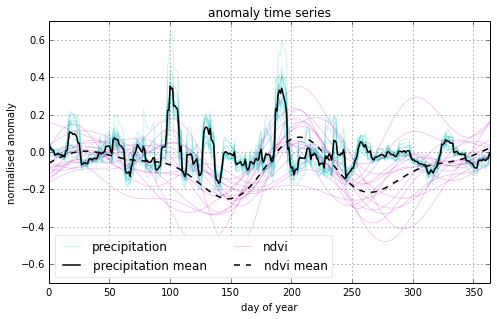

In [15]:
# register all of the GDAL drivers
gdal.AllRegister()

# open the image
ds = gdal.Open(path_base)
if ds is None:
    print ('Could not open base file')
    sys.exit(1)

# get image size
rows = ds.RasterYSize
cols = ds.RasterXSize
bands = ds.RasterCount

# get the band and block sizes
band = ds.GetRasterBand(1)
base = band.ReadAsArray()
nan = band.GetNoDataValue()

#blockSizes = utils.GetBlockSize(band)
xBlockSize = 70
yBlockSize = 70

files_trmm = listall(folder_trmm)
files_ndvi = listall(folder_ndvi)
if len(files_ndvi) != len(files_trmm):
    print ('Input length time series not equal: x ', len(files_ndvi), 'y ', len(files_trmm))
    sys.exit()
else:
    print ('Input length time series equal: series1', len(files_ndvi), 'series2', len(files_trmm))
    
# loop through the rows
for i in range(rowx-1, rowx, yBlockSize): #(0, rows, yBlockSize)
    if i + yBlockSize < rows:
        numRows = yBlockSize
    else:
        numRows = rows - i
    
    # loop through the columns
    for j in range(coly-1, coly, xBlockSize):# (0, cols, xBlockSize)
        if j + xBlockSize < cols:
            numCols = xBlockSize
        else:
            numCols = cols - j
        
        print (j, i, numCols, numRows)
        # set base array to fill 
        ap_trmm = np.zeros(shape=(len(files_trmm),numRows,numCols), dtype=np.float32)
        ap_ndvi = np.zeros(shape=(len(files_ndvi),numRows,numCols), dtype=np.float32)
        
        # select blocks from trmm and ndvi files
        for m in range(len(files_trmm)):
            raster = gdal.Open(files_trmm[m], gdal.GA_ReadOnly)
            band = raster.GetRasterBand(1)            
            ap_trmm[m] = band.ReadAsArray(j, i, numCols, numRows).astype(np.float)
                
            raster = gdal.Open(files_ndvi[m], gdal.GA_ReadOnly)
            band = raster.GetRasterBand(1)            
            ap_ndvi[m] = band.ReadAsArray(j, i, numCols, numRows).astype(np.float)

        # reshape from 3D to 2D
        ap_trmm = ap_trmm.reshape((int(ap_trmm.shape[0]),int(ap_trmm.shape[1]*ap_trmm.shape[2]))).T
        ap_ndvi = ap_ndvi.reshape((int(ap_ndvi.shape[0]),int(ap_ndvi.shape[1]*ap_ndvi.shape[2]))).T

b = np.ascontiguousarray(ap_trmm).view(np.dtype((np.void, ap_trmm.dtype.itemsize * ap_trmm.shape[1])))
_, idx = np.unique(b, return_index=True)

unique_a = ap_trmm[idx]
unique_b = ap_ndvi[idx]

plt.figure(figsize=(7,4.5))
for i in unique_a:
    p1, = plt.plot(i, color='c', alpha=0.2)
for j in unique_b:
    p2, = plt.plot(j, color='m', alpha=0.2)

p3, = plt.plot(unique_a.mean(axis=0), 'k-', lw=1.5)
p4, = plt.plot(unique_b.mean(axis=0), 'k--', lw=1.5)


plt.grid(axis='both')
plt.ylim(-0.7,0.7)
plt.xlim(0,364)
plt.xlabel('day of year')
plt.ylabel('normalised anomaly')
plt.title('anomaly time series')
leg = plt.legend([p1,p3,p2,p4],['precipitation','precipitation mean','ndvi','ndvi mean'],ncol=2, loc=3)
leg.get_frame().set_linewidth(0.5)
leg.get_frame().set_edgecolor('lightgray')
plt.tight_layout()        
#plt.savefig(r'C:\Users\lenovo\Documents\HOME\2015-02-05_pics4progress//raw_2006_Dry_ndvi_trmm.png', dpi=400)

### Apply HANTS on the precipitation data

In [16]:
m1, m2 = unique_a.mean(axis=0),unique_b.mean(axis=0) # m1 : precipitation, m2 : ndvi

# m1 *= 1000
# m1_hants_Hi = HANTS(sample_count=len(m1),inputs=m1[None], frequencies_considered_count=6, outliers_to_reject='Hi', low=-300)
# m1_hants_Lo = HANTS(sample_count=len(m1),inputs=m1[None], frequencies_considered_count=6, outliers_to_reject='Lo', low=-300)
# m1_hants_No = HANTS(sample_count=len(m1),inputs=m1[None], frequencies_considered_count=6, outliers_to_reject='None', low=-300)

# m1_hants_Hi /= 1000
# m1_hants_Lo /= 1000
# m1_hants_No /= 1000
# m1 /= 1000

# plt.plot(m1_hants_Hi.ravel(), label='Hi' )
# plt.plot(m1_hants_Lo.ravel(), label='Lo' )
# plt.plot(m1_hants_No.ravel(), label='None' )
# plt.plot(m1, label='m1')
# plt.plot(m2, 'k--', label='m2')
# plt.legend()
# # new m1 is
# m1 = m1_hants_No.ravel()

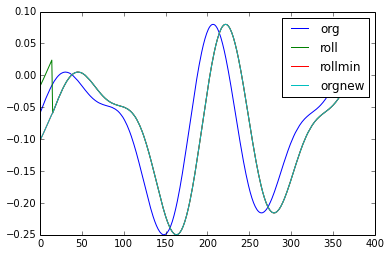

In [102]:
plt.plot(m2, label="org")
m2_roll = np.roll(m2,15)
plt.plot(m2_roll, label="roll")
m2_roll[0:15] = m2_roll[0:15]-0.085
plt.plot(m2_roll, label="rollmin")
m2 = m2_roll
plt.plot(m2, label="orgnew")
plt.legend()

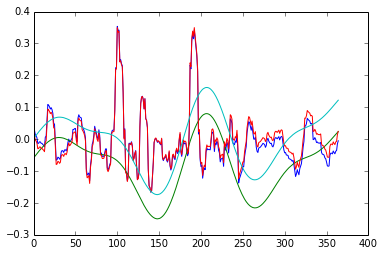

In [17]:
plt.plot(m1)
plt.plot(m2)
plt.plot(scipy.signal.detrend(m1))
plt.plot(scipy.signal.detrend(m2))
#m1 = scipy.signal.detrend(m1)
#m2 = scipy.signal.detrend(m2)

###  Extract the mean of the unique timeseries, and choose how to extend the signal. Padding with zeroes (left, right or both sides) or repeat the signal

In [84]:
# repeat or pead signals number of times
tile_no = 100
extend = 0
def pad_extend(m1, m2, tile_no=tile_no, extend=extend):
    """
    Input 'm1':
    Signal 1
    Input 'm2':
    Signal 2
    Input 'extend':
    0 = repeat signal
    1 = padd with zeroes left
    2 = padd with zeroes right
    3 = padd with zeroes on both sides
    Input 'tile_no':
    number of times to pad or extend the signal
    
    Output 
    x,y,t = repeated/padded signals + evenly spaced interval of the range
    """
    
    
    if extend == 0:
        x = np.tile(m1, tile_no+1)
        y = np.tile(m2, tile_no+1)
    elif extend == 1:
        x = np.lib.pad(m1, (len(m1)*(tile_no),0), 'constant', constant_values=0)
        y = np.lib.pad(m2, (len(m2)*(tile_no),0), 'constant', constant_values=0)    
    
    elif extend == 2:
        x = np.lib.pad(m1, (0,len(m1)*(tile_no)), 'constant', constant_values=0)
        y = np.lib.pad(m2, (0,len(m1)*(tile_no)), 'constant', constant_values=0)    
    
    elif extend == 3:
        x = np.lib.pad(m1, (len(m1)*tile_no/2,len(m1)*(tile_no/2)), 'constant', constant_values=0)
        y = np.lib.pad(m2, (len(m2)*tile_no/2,len(m1)*(tile_no/2)), 'constant', constant_values=0)    
    
    if len(x) % 2 != 0:
        x = x[:-1]
    
    if len(y) % 2 != 0:
        y = y[:-1]
        
    t = np.arange(x.shape[0])
    return x,y,t

In [85]:
x,y,t=pad_extend(m1,m2)

In [86]:
print (x.shape, y.shape)

((36864L,), (36864L,))


Plot the two timeseries as is

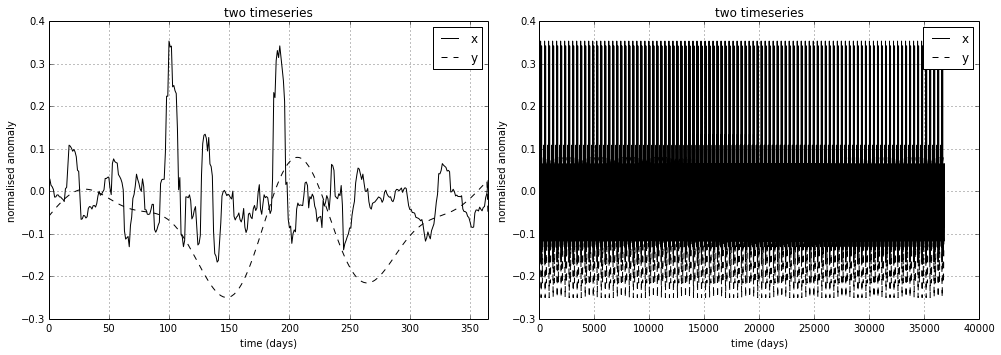

In [87]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.grid()

plt.plot(t,x, 'k-', lw=1, label='x')
plt.plot(t,y, 'k--', lw=1, label='y')
plt.xlim(0,365)

plt.ylabel('normalised anomaly')
plt.xlabel('time (days)')
plt.title('two timeseries')
plt.legend()

plt.subplot(122)
plt.grid()

plt.plot(t,x, 'k-', lw=1, label='x')
plt.plot(t,y, 'k--', lw=1, label='y')
#plt.xlim(0,365)

plt.ylabel('normalised anomaly')
plt.xlabel('time (days)')
plt.title('two timeseries')
plt.legend()
plt.gcf().tight_layout()

### Compute all the components we need: frequencies, power spectral density of x, power spectral density of y, cross spectral density between x and y, coherence between x and y, phase spectrum between x and y and last the phase uncertainty between x and y.

In [88]:
f, fkx, fky, cxy, ph, coh = mtem(x,y)
phif = mtem_unct(x,y,coh, mc_no=5)

('x size', (36864L,))
('y size', (36864L,))
('iteration no is', 5)


In [89]:
vspan_start = 0.0026
vspan_end = 0.0028
xlim_start = 0.000
xlim_end = 0.012

plot everything in one plot

In [91]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

def plotCrossSpectral(f,ph,coh,phif):
    plt.figure(figsize=(14,4.5))
    
    ## PLOT 5
    plt.subplot(121)
    
    plt.grid(axis='y')
    plt.plot(f,coh, 'y')
    
    plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.2)
    plt.axvspan(0.0054,0.0056, color='gray', alpha=0.2)
    plt.axvspan(0.0081,0.0083, color='gray', alpha=0.2)
    plt.axvspan(0.0108,0.0110, color='gray', alpha=0.2)
    
    plt.xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
    plt.xlim(xlim_start,xlim_end)
    plt.ylim(0,1.01)
    
    plt.ylabel('coherence')
    plt.xlabel('frequency (Hz)')
    plt.title('coherence x/y with repeated ts: '+str(tile_no))
    
    ## PLOT 9
    rad2time = ph/(2*np.pi*f)
    mtcl2time = phif/(2*np.pi*f)
    neg_time= np.where(rad2time<0)
    dur_cycl = (1/f)
    rad2time[neg_time] = rad2time[neg_time]+dur_cycl[neg_time]
    
    
    ax = host_subplot(122, axes_class=AA.Axes)
    
    p1 = plt.Rectangle((0, 0), 1, 1, fc='c', ec='c')
    p2, = ax.plot(f, rad2time, color='m', zorder=5, label='Phase')
    p3, = ax.plot(f, dur_cycl, color='gray', linestyle='-.', zorder=5, label='Period')
    p4, = ax.plot(f, dur_cycl/2, color='gray', linestyle='--', zorder=5, label='Halve period')
    
    ax.fill_between(f,(rad2time+mtcl2time),(rad2time-mtcl2time), where=(((rad2time+mtcl2time)<dur_cycl)), 
                 facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
    ax.fill_between(f,(rad2time-mtcl2time),dur_cycl, where=(((rad2time+mtcl2time)>dur_cycl)),
                 facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
    ax.fill_between(f,(rad2time+mtcl2time)-dur_cycl, where=(((rad2time+mtcl2time)>0)),
                 facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
    ax.fill_between(f,((rad2time-mtcl2time)+dur_cycl),dur_cycl, where=((rad2time-mtcl2time)<0), 
                 facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
    
    ax.set_xlim([xlim_start,xlim_end])
    ax.set_ylim([0,365])
    ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
    ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
    
    ax.set_xlabel('frequency (Hz)')
    ax.set_ylabel('phase (day)')
    ax.set_title('t (month)', loc='left', fontsize=10)
    
    p5= plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.2, zorder=-1)
    plt.axvspan(0.0054,0.0056, color='gray', alpha=0.2)
    plt.axvspan(0.0081,0.0083, color='gray', alpha=0.2)
    plt.axvspan(0.0108,0.0110, color='gray', alpha=0.2)
    #axvspan(0.099,0.101, color='gray', alpha=0.1, zorder=0)
    
    ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
    ax2.set_xlabel('phase spectrum x/y + uncertainty')
    ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
    ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
    ax2.axis["right"].major_ticklabels.set_visible(False)
    ax2.xaxis.label.set_size(2)
    
    
    lg = plt.legend([p3,p4], ['single period','halve period'], ncol=1)
    lg.get_frame().set_ec('lightgray')
    lg.get_frame().set_lw(0.5)
    plt.grid(axis='y', zorder=0 )
    
    plt.gcf().tight_layout()
    #plt.savefig(r'C:\Users\lenovo\Documents\HOME//nodetrending_2007_Wet_nohants.png', dpi=400)
    
    # frequency index
    #f_lb = 0.0054 # vspan_start 
    #f_ub = 0.0056 # vspan_end
    #f_ix = np.where((f > f_lb) * (f < f_ub))[0]
    #p_r2t = np.mean(rad2time[f_ix], -1)
    #p_ph = np.mean(ph[f_ix], -1)
    #print ('phase in radian is', round(p_ph,2))
    #print ('which correspond to', round(p_r2t,2), 'day')
    #plt.savefig(r'C:\Users\lenovo\Documents\HOME\2015-02-05_pics4progress//nodetrending_2006_Wet_nohants.png', dpi=400)
    plt.show()
    plt.close()

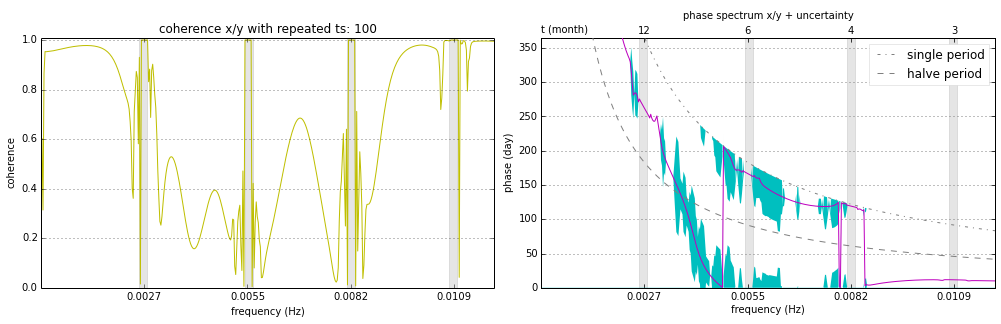

In [94]:
plotCrossSpectral(f,ph,coh,phif)

In [ ]:
for i in range(1,200,5):
    print (i)

    
    m1, m2 = unique_a.mean(axis=0),unique_b.mean(axis=0)

    tile_no = i

    x = np.tile(m1, tile_no)
    y = np.tile(m2, tile_no)

    if len(x) % 2 != 0:
        x = x[:-1]

    if len(y) % 2 != 0:
        y = y[:-1]

    t = np.arange(x.shape[0])


    f, fkx, fky, cxy, ph, coh = mtem(x,y)
    phif = mtem_unct(x,y,coh, mc_no=20)


    vspan_start = 0.0026
    vspan_end = 0.0028
    xlim_start = 0.000
    xlim_end = 0.012



    from mpl_toolkits.axes_grid1 import host_subplot
    import mpl_toolkits.axisartist as AA

    plt.figure(figsize=(14,4.5))

    ## PLOT 5
    plt.subplot(121)

    plt.grid(axis='y')
    plt.plot(f,coh, 'y')

    plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.2)
    plt.axvspan(0.0054,0.0056, color='gray', alpha=0.2)
    plt.axvspan(0.0081,0.0083, color='gray', alpha=0.2)
    plt.axvspan(0.0108,0.0110, color='gray', alpha=0.2)

    plt.xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
    plt.xlim(xlim_start,xlim_end)
    plt.ylim(0,1.01)

    plt.ylabel('coherence')
    plt.xlabel('frequency (Hz)')
    plt.title('coherence x/y with repeated ts: '+str(tile_no))

    ## PLOT 9
    rad2time = ph/(2*np.pi*f)
    mtcl2time = phif/(2*np.pi*f)
    neg_time= np.where(rad2time<0)
    dur_cycl = (1/f)
    rad2time[neg_time] = rad2time[neg_time]+dur_cycl[neg_time]


    ax = host_subplot(122, axes_class=AA.Axes)

    p1 = plt.Rectangle((0, 0), 1, 1, fc='c', ec='c')
    p2, = ax.plot(f, rad2time, color='m', zorder=5, label='Phase')
    p3, = ax.plot(f, dur_cycl, color='gray', linestyle='-.', zorder=5, label='Period')
    p4, = ax.plot(f, dur_cycl/2, color='gray', linestyle='--', zorder=5, label='Halve period')

    ax.fill_between(f,(rad2time+mtcl2time),(rad2time-mtcl2time), where=(((rad2time+mtcl2time)<dur_cycl)), 
                 facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
    ax.fill_between(f,(rad2time-mtcl2time),dur_cycl, where=(((rad2time+mtcl2time)>dur_cycl)),
                 facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
    ax.fill_between(f,(rad2time+mtcl2time)-dur_cycl, where=(((rad2time+mtcl2time)>0)),
                 facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
    ax.fill_between(f,((rad2time-mtcl2time)+dur_cycl),dur_cycl, where=((rad2time-mtcl2time)<0), 
                 facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)

    ax.set_xlim([xlim_start,xlim_end])
    ax.set_ylim([0,365])
    ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
    ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])

    ax.set_xlabel('frequency (Hz)')
    ax.set_ylabel('phase (day)')
    ax.set_title('t (month)', loc='left', fontsize=10)

    p5= plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.2, zorder=-1)
    plt.axvspan(0.0054,0.0056, color='gray', alpha=0.2)
    plt.axvspan(0.0081,0.0083, color='gray', alpha=0.2)
    plt.axvspan(0.0108,0.0110, color='gray', alpha=0.2)
    #axvspan(0.099,0.101, color='gray', alpha=0.1, zorder=0)

    ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
    ax2.set_xlabel('phase spectrum x/y + uncertainty')
    ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
    ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
    ax2.axis["right"].major_ticklabels.set_visible(False)
    ax2.xaxis.label.set_size(2)


    lg = plt.legend([p3,p4], ['single period','halve period'], ncol=1)
    lg.get_frame().set_ec('lightgray')
    lg.get_frame().set_lw(0.5)
    plt.grid(axis='y', zorder=0 )

    plt.gcf().tight_layout()
    plt.savefig(r'C:\Users\lenovo\Documents\HOME\Figures phase spectrum coherence//coherence_phasespectrum'+str(tile_no)+'.png', dpi=400)

    # frequency index
    f_lb = vspan_start
    f_ub = vspan_end
    f_ix = np.where((f > f_lb) * (f < f_ub))[0]
    p_r2t = np.mean(rad2time[f_ix], -1)
    p_ph = np.mean(ph[f_ix], -1)
    print ('phase in radian is', round(p_ph,2))
    print ('which correspond to', round(p_r2t,2), 'day')
    plt.show()
    plt.close()

phase in radian is 2.31
which correspond to 136.36 day


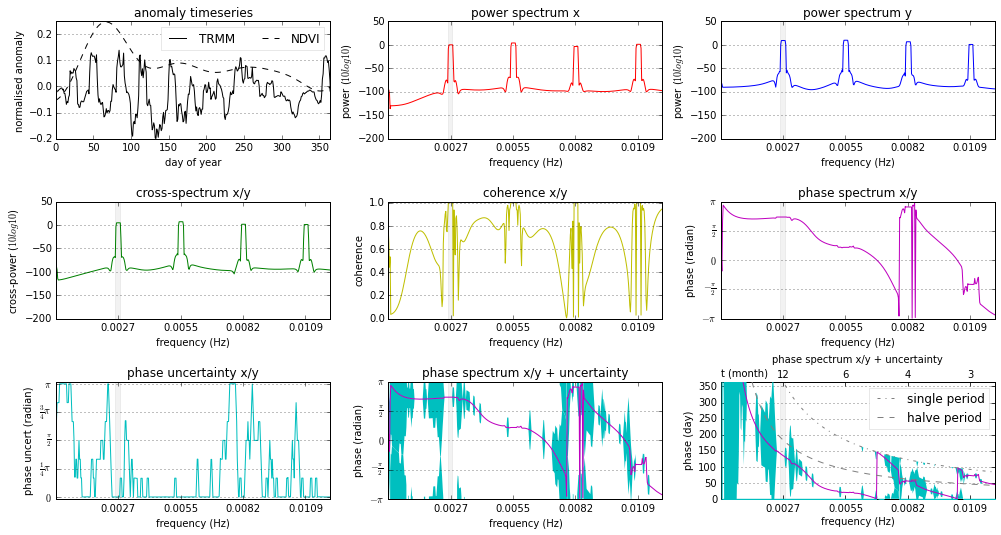

In [72]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

plt.figure(figsize=(14,7.5))

## PLOT 1
plt.subplot(331)
plt.grid(axis='y')

plt.plot(t,x, 'k-', lw=1, label='TRMM')
plt.plot(t,y, 'k--', lw=1, label='NDVI')

plt.xlim(0,364)
#plt.ylim(-0.2,0.2)
plt.yticks([-0.2,-0.1,0,0.1,0.2])
plt.ylabel('normalised anomaly')
plt.xlabel('day of year')
plt.title('anomaly timeseries')
leg = plt.legend(loc=1, frameon=True, ncol=2)
leg.get_frame().set_edgecolor('lightgray')
leg.get_frame().set_lw(0.5)

## PLOT 2
plt.subplot(332)
plt.grid(axis='y')

plt.plot(f,dB(fkx), 'r-', lw=1)
plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
plt.xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
plt.xlim(xlim_start,xlim_end)
#plt.ylim(-5,35)

plt.ylabel('power ($10log10$)')
plt.xlabel('frequency (Hz)')
plt.title('power spectrum x')
#plt.gcf().tight_layout()

## PLOT 3
plt.subplot(333)
plt.grid(axis='y')
plt.plot(f,dB(fky), 'b-', lw=1)
plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
plt.xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
plt.xlim(xlim_start,xlim_end)
#plt.ylim(-5,35)

plt.ylabel('power ($10log10$)')
plt.xlabel('frequency (Hz)')
plt.title('power spectrum y')

## PLOT 4
plt.subplot(334)
plt.grid(axis='y')

plt.plot(f,dB(cxy), 'g-', lw=1)
plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
plt.xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
plt.xlim(xlim_start,xlim_end)
#plt.ylim(-5,35)

plt.ylabel('cross-power ($10log10$)')
plt.xlabel('frequency (Hz)')
plt.title('cross-spectrum x/y')
#plt.gcf().tight_layout()

## PLOT 5
plt.subplot(335)
plt.grid(axis='y')

plt.plot(f,coh, 'y')

plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
plt.xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
plt.xlim(xlim_start,xlim_end)
plt.ylim(0,1.01)

plt.ylabel('coherence')
plt.xlabel('frequency (Hz)')
plt.title('coherence x/y')


## PLOT 6
plt.subplot(336)
plt.grid(axis='y')

plt.plot(f,ph, 'm', lw=1)
plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
           ['$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
plt.xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
plt.xlim(xlim_start,xlim_end)
plt.ylim(-np.pi,np.pi)

plt.ylabel('phase (radian)')
plt.xlabel('frequency (Hz)')
plt.title('phase spectrum x/y')
#plt.gcf().tight_layout()

## PLOT 7
plt.subplot(337)
plt.grid(axis='y')

plt.plot(f,phif, 'c', lw=1)
plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
plt.yticks([0,1./4*np.pi, np.pi/2, 3./4*np.pi,np.pi],
           [r'$0$', r'$\frac{1}{4}\pi$', r'$\frac{\pi}{2}$', r'$\frac{3}{4}\pi$', r'$\pi$'])
plt.xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])
plt.xlim(xlim_start,xlim_end)
plt.ylim(-0.05,3.2)

plt.ylabel('phase uncert (radian)')
plt.xlabel('frequency (Hz)')
plt.title('phase uncertainty x/y')

## PLOT 8
plt.subplot(338)
plt.grid(axis='y')
plt.plot(f,ph, 'm')

plt.fill_between(f,ph,(ph-phif),facecolor='c' ,edgecolor='c', lw=0.0)#, where=(ph-phif)>=-np.pi)
plt.fill_between(f,ph,(ph+phif),facecolor='c' ,edgecolor='c', lw=0.0)

plt.fill_between(f,(ph+2*np.pi),((ph+2*np.pi)-phif), where=(ph-phif)<=-np.pi,
                 facecolor='c' ,edgecolor='c', lw=0.0)
plt.fill_between(f,(ph-2*np.pi),((ph-2*np.pi)+phif), where=(ph+phif)>=np.pi,
                 facecolor='c' ,edgecolor='c', lw=0.0)

plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
           ['$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

plt.xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))],[str(0.0027),str(0.0055),str(0.0082),str(0.0109)])


plt.xlim(xlim_start,xlim_end)
plt.ylim(-np.pi,np.pi)

plt.ylabel('phase (radian)')
plt.xlabel('frequency (Hz)')
plt.title('phase spectrum x/y + uncertainty')
#plt.gcf().tight_layout()



## PLOT 9
rad2time = ph/(2*np.pi*f)
mtcl2time = phif/(2*np.pi*f)
neg_time= np.where(rad2time<0)
dur_cycl = (1/f)
rad2time[neg_time] = rad2time[neg_time]+dur_cycl[neg_time]


ax = host_subplot(339, axes_class=AA.Axes)

p1 = plt.Rectangle((0, 0), 1, 1, fc='c', ec='c')
p2, = ax.plot(f, rad2time, color='m', zorder=5, label='Phase')
p3, = ax.plot(f, dur_cycl, color='gray', linestyle='-.', zorder=5, label='Period')
p4, = ax.plot(f, dur_cycl/2, color='gray', linestyle='--', zorder=5, label='Halve period')

ax.fill_between(f,(rad2time+mtcl2time),(rad2time-mtcl2time), where=(((rad2time+mtcl2time)<dur_cycl)), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f,(rad2time-mtcl2time),dur_cycl, where=(((rad2time+mtcl2time)>dur_cycl)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f,(rad2time+mtcl2time)-dur_cycl, where=(((rad2time+mtcl2time)>0)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f,((rad2time-mtcl2time)+dur_cycl),dur_cycl, where=((rad2time-mtcl2time)<0), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)

ax.set_xlim([xlim_start,xlim_end])
ax.set_ylim([0,365])
ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax.set_xticklabels([str(0.0027),str(0.0055),str(0.0082),str(0.0109)])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (month)', loc='left', fontsize=10)

p5= plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1, zorder=-1)
#axvspan(0.099,0.101, color='gray', alpha=0.1, zorder=0)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xlabel('phase spectrum x/y + uncertainty')
ax2.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])
ax2.set_xticklabels([str(12),str(6),str(4),str(3)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)


lg = plt.legend([p3,p4], ['single period','halve period'], ncol=1)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
plt.grid(axis='y', zorder=0 )

plt.gcf().tight_layout()
#plt.savefig(r'C:\Users\lenovo\Documents\HOME\Figures paper//y_psdcsdcohphase.png', dpi=400)

# frequency index
f_lb = vspan_start
f_ub = vspan_end
f_ix = np.where((f > f_lb) * (f < f_ub))[0]
p_r2t = np.mean(rad2time[f_ix], -1)
p_ph = np.mean(ph[f_ix], -1)
print ('phase in radian is', round(p_ph,2))
print ('which correspond to', round(p_r2t,2), 'day')

So now only making some plots of the result. First the psd of x and y.

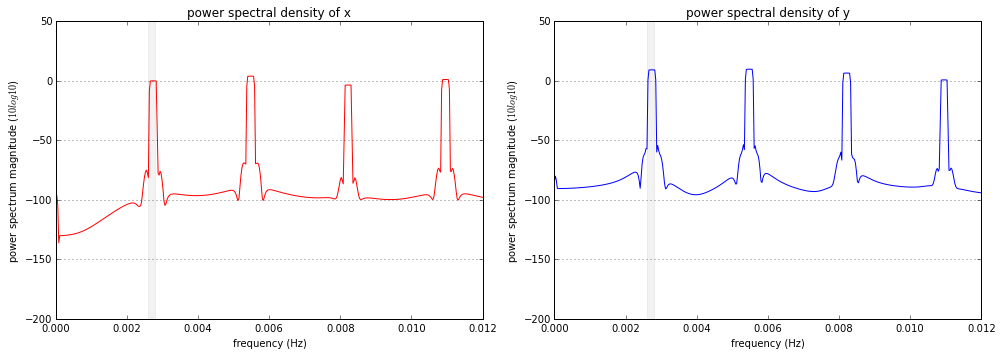

In [66]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.grid(axis='y')

plt.plot(f,dB(fkx), 'r-', lw=1)
plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
plt.xlim(xlim_start,xlim_end)
#plt.axvspan(0.099,0.101, color='gray', alpha=0.1)

#plt.ylim(-5,35)

plt.ylabel('power spectrum magnitude ($10log10$)')
plt.xlabel('frequency (Hz)')
plt.title('power spectral density of x')
plt.gcf().tight_layout()

plt.subplot(122)
plt.grid(axis='y')
plt.plot(f,dB(fky), 'b-', lw=1)
plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
#plt.axvspan(0.099,0.101, color='gray', alpha=0.1)
plt.xlim(xlim_start,xlim_end)
#plt.ylim(-5,35)

plt.ylabel('power spectrum magnitude ($10log10$)')
plt.xlabel('frequency (Hz)')
plt.title('power spectral density of y')
plt.gcf().tight_layout()

Timeseries of x contains noise and two components relating to frequency 0.1 and 0.047 Hz. Psd of y only contains one component related to frequency 0.1 Hz. Next we plot the cross spectral density and the corresponding coherence, which is the normalised csd.

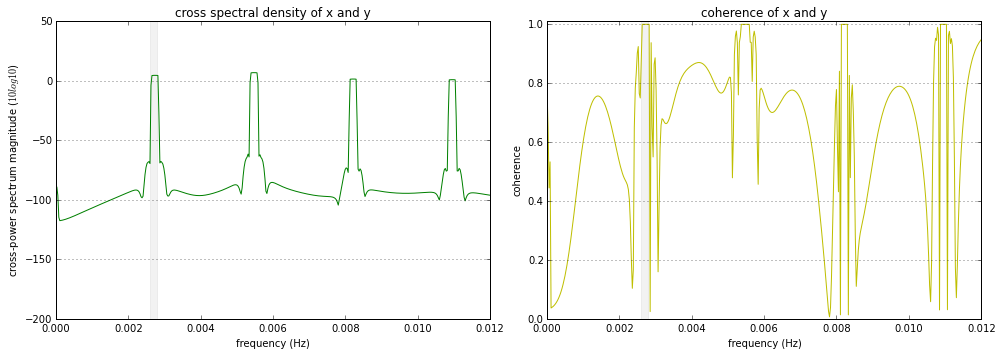

In [67]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.grid(axis='y')

plt.plot(f,dB(cxy), 'g-', lw=1)
plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
#plt.axvspan(0.099,0.101, color='gray', alpha=0.1)
plt.xlim(xlim_start,xlim_end)
#plt.ylim(-5,35)

plt.ylabel('cross-power spectrum magnitude ($10log10$)')
plt.xlabel('frequency (Hz)')
plt.title('cross spectral density of x and y')
plt.gcf().tight_layout()

plt.subplot(122)
plt.grid(axis='y')

plt.plot(f,coh, 'y')

plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
#plt.axvspan(0.099,0.101, color='gray', alpha=0.1)
plt.xlim(xlim_start,xlim_end)
plt.ylim(0,1.01)

plt.ylabel('coherence')
plt.xlabel('frequency (Hz)')
plt.title('coherence of x and y')

plt.gcf().tight_layout()

Cross spectral density shows single peak for 0.1 Hz and the other peak of 0.047 Hz is still visible but weaker. In the coherence plot its visible there is a clear coherence for the 0.1 Hz peak and the two timeseries are near 0 coherent for the frequency of 0.047 Hz. Next we plot the phase spectrum and phase uncertainty seperately.

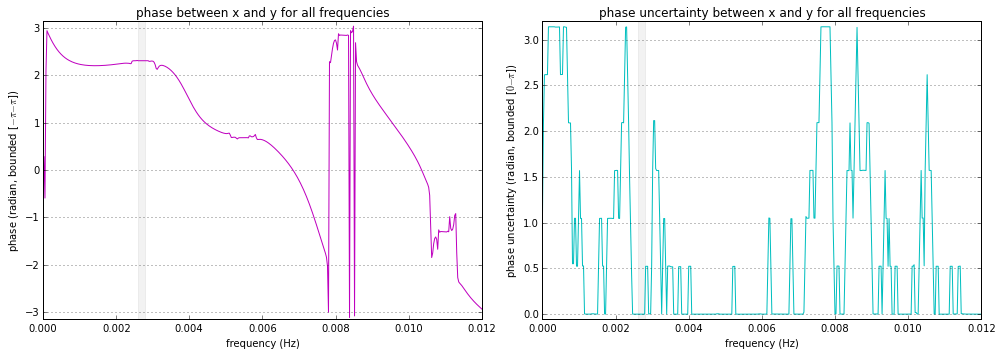

In [68]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.grid(axis='y')

plt.plot(f,ph, 'm', lw=1)
plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
#plt.axvspan(0.099,0.101, color='gray', alpha=0.1)
plt.xlim(xlim_start,xlim_end)
plt.ylim(-np.pi,np.pi)

plt.ylabel('phase (radian, bounded [$-{\pi}-{\pi}$])')
plt.xlabel('frequency (Hz)')
plt.title('phase between x and y for all frequencies')
plt.gcf().tight_layout()

plt.subplot(122)
plt.grid(axis='y')

plt.plot(f,phif, 'c', lw=1)
plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
#plt.axvspan(0.099,0.101, color='gray', alpha=0.1)
plt.xlim(xlim_start,xlim_end)
plt.ylim(-0.05,3.2)

plt.ylabel('phase uncertainty (radian, bounded [$0-{\pi}$])')
plt.xlabel('frequency (Hz)')
plt.title('phase uncertainty between x and y for all frequencies')
plt.gcf().tight_layout()

Phase of frequency 0.1 Hz is stable at 1 radian. Phase uncertainty shows high uncertainty for all frequencies excempt frequency corresponding to 0.1 Hz. So by combining the phase and phase uncertainty we get last two plots with phase in radian and phase in time domain units, which are hours this time.

-c:28: RuntimeWarning: invalid value encountered in true_divide
-c:30: RuntimeWarning: invalid value encountered in less
-c:31: RuntimeWarning: divide by zero encountered in true_divide
-c:42: RuntimeWarning: invalid value encountered in less
-c:46: RuntimeWarning: invalid value encountered in greater
-c:48: RuntimeWarning: invalid value encountered in less


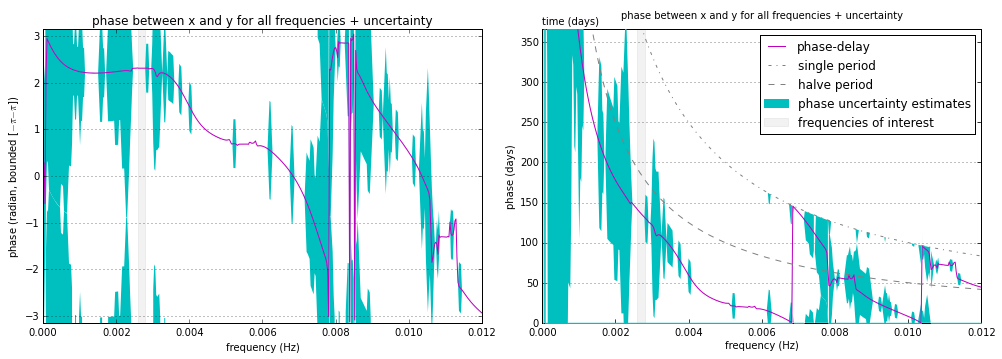

In [69]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.grid(axis='y')
plt.plot(f,ph, 'm')
plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1)
#plt.axvspan(0.099,0.101, color='gray', alpha=0.1)

plt.fill_between(f,ph,(ph-phif),facecolor='c' ,edgecolor='c', lw=0.0)#, where=(ph-phif)>=-np.pi)
plt.fill_between(f,ph,(ph+phif),facecolor='c' ,edgecolor='c', lw=0.0)

plt.fill_between(f,(ph+2*np.pi),((ph+2*np.pi)-phif), where=(ph-phif)<=-np.pi,
                 facecolor='c' ,edgecolor='c', lw=0.0)
plt.fill_between(f,(ph-2*np.pi),((ph-2*np.pi)+phif), where=(ph+phif)>=np.pi,
                 facecolor='c' ,edgecolor='c', lw=0.0)


plt.xlim(xlim_start,xlim_end)
plt.ylim(-np.pi,np.pi)

plt.ylabel('phase (radian, bounded [$-{\pi}-{\pi}$])')
plt.xlabel('frequency (Hz)')
plt.title('phase between x and y for all frequencies + uncertainty')
plt.gcf().tight_layout()

from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

rad2time = ph/(2*np.pi*f)
mtcl2time = phif/(2*np.pi*f)
neg_time= np.where(rad2time<0)
dur_cycl = (1/f)
rad2time[neg_time] = rad2time[neg_time]+dur_cycl[neg_time]


ax = host_subplot(122, axes_class=AA.Axes)

p1 = plt.Rectangle((0, 0), 1, 1, fc='c', ec='c')
p2, = ax.plot(f, rad2time, color='m', zorder=5, label='Phase')
p3, = ax.plot(f, dur_cycl, color='gray', linestyle='-.', zorder=5, label='Period')
p4, = ax.plot(f, dur_cycl/2, color='gray', linestyle='--', zorder=5, label='Halve period')

ax.fill_between(f,(rad2time+mtcl2time),(rad2time-mtcl2time), where=(((rad2time+mtcl2time)<dur_cycl)), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f,(rad2time-mtcl2time),dur_cycl, where=(((rad2time+mtcl2time)>dur_cycl)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f,(rad2time+mtcl2time)-dur_cycl, where=(((rad2time+mtcl2time)>0)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f,((rad2time-mtcl2time)+dur_cycl),dur_cycl, where=((rad2time-mtcl2time)<0), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)

ax.set_xlim([xlim_start,xlim_end])
ax.set_ylim([0,366])
#ax.set_xticks([(1/366),(1./(366./2)),(1./(366./3)),(1./(366./4))])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (days)')
ax.set_title('time (days)', loc='left', fontsize=10)

p5= plt.axvspan(vspan_start,vspan_end, color='gray', alpha=0.1, zorder=-1)
#axvspan(0.099,0.101, color='gray', alpha=0.1, zorder=0)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xlabel('phase between x and y for all frequencies + uncertainty')
ax2.set_xticks([0.05,0.1,0.15,0.2])#0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
ax2.set_xticklabels([str(round(1./0.05, 1)),str(round(1./0.1,1)),str(round(1./0.15,1)),str(round(1./0.2,1))])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)

plt.legend([p2,p3,p4,p1,p5], ['phase-delay','single period','halve period','phase uncertainty estimates', 'frequencies of interest'])
plt.grid(axis='y', zorder=0 )

plt.tight_layout()

plt.show()

For plot on the right matplotlib shows some glimpses as he found it difficult to plot it perfectly. It's forgiven.
So to get some results out of the plot. Apply a bandpass filter between 0.099 and 0.101 Hz to see the phase in radian and in hour. 

In [70]:
# frequency index
f_lb = vspan_start
f_ub = vspan_end
f_ix = np.where((f > f_lb) * (f < f_ub))[0]
p_r2t = np.mean(rad2time[f_ix], -1)
p_ph = np.mean(ph[f_ix], -1)
print ('phase in radian is', round(p_ph,2))
print ('which correspond to',round(p_r2t,2), 'days (',(365-round(p_r2t,2))*-1,')')
    

phase in radian is 2.31
which correspond to 136.36 days ( -228.64 )


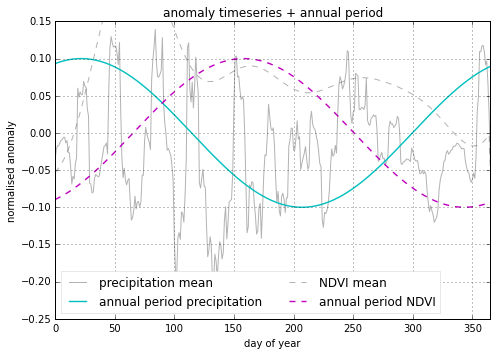

In [71]:
#x_  = 4 * np.sin(2*(np.pi/10)*t)
#y_  = 4 * np.sin(2*(np.pi/10)*t+1)
y0  = 0.10 * np.sin(2*(np.pi/(1./0.0027))*t+1.2)
y1  = 0.10 * np.sin(2*(np.pi/(1./0.0027))*t+1.2-p_ph)
#x1 = 4 * np.sin(2*(np.pi/(1./0.1)*t-p_ph))#ps)
#y1 = 4 * np.sin(2*(np.pi/(1./0.1)*t))
plt.figure(figsize=(7,5))
#plt.subplot(121)
plt.grid()

p1, = plt.plot(t,x, 'k-', alpha=0.3,lw=1, label='precipitation mean')
p2, = plt.plot(t,y, 'k--', alpha=0.3, lw=1, label='NDVI mean')

#plt.plot(t,x1, 'r', lw=1, label='x1')
p3, = plt.plot(t,y0, 'c', lw=1.4, label='annual period precipitation')
p4, = plt.plot(t,y1, 'm--', lw=1.4, label='annual period NDVI')
#plt.plot(t,x2, 'b-', lw=1, label='x2')
#plt.plot(t,y1, 'g.', lw=1, label='y1')
#plt.plot(t,y2, 'm-', lw=1, label='y2')

plt.xlim(0,365)

plt.ylabel('normalised anomaly')
plt.xlabel('day of year')
plt.title('anomaly timeseries + annual period')
plt.ylim(-0.25,0.15)
leg = plt.legend([p1,p3,p2,p4],['precipitation mean','annual period precipitation',
                                'NDVI mean', 'annual period NDVI'],ncol=2, loc=3)
leg.get_frame().set_lw(0.5)
leg.get_frame().set_ec('lightgray')
#leg.get_frame().set_alpha(0.5)
plt.tight_layout()
#plt.savefig(r'C:\Users\lenovo\Documents\HOME\Figures paper//y_anomaly_annual_period', dpi=400)